In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
USE_PAIRPLOT = False

In [3]:
df = pd.read_csv(filepath_or_buffer="dataset/diamonds.csv", 
                 usecols=["carat", "cut", "color", "clarity", "depth", "table", "price", "x", "y", "z"])

In [4]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [5]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [7]:
if USE_PAIRPLOT:
    sns.pairplot(df)

In [8]:
def split_into_groups(df):
    binary = pd.DataFrame()
    categorical = pd.DataFrame()
    numerical = pd.DataFrame()
    
    for column in df:
        if df[column].dtypes == "float64" or df[column].dtypes == "int64":
            numerical[column] = df[column]
        if df[column].dtypes == "object":
            categorical[column] = df[column]
        if df[column].dtypes == "boolean":
            binary[column] == df[column]

    return binary, categorical, numerical

In [9]:
binary_df, categorical_df, numerical_df = split_into_groups(df)

In [10]:
from library.dm import split_by_difficulty_binary, \
                       split_by_difficulty_categorical, \
                       split_by_difficulty_numerical

binary_df = split_by_difficulty_binary(binary_df)
categorical_df = split_by_difficulty_categorical(categorical_df)
numerical_df = split_by_difficulty_numerical(numerical_df)

In [11]:
binary_df

,difficulty


In [12]:
categorical_df
print(categorical_df.loc[categorical_df["difficulty"] == "conflict"].shape)
print(categorical_df.loc[categorical_df["difficulty"] != "conflict"].shape)

(47493, 4)
(6447, 4)


In [13]:
numerical_df
print(numerical_df.loc[numerical_df["difficulty"] == "conflict"].shape)
print(numerical_df.loc[numerical_df["difficulty"] != "conflict"].shape)

(41913, 8)
(12027, 8)


In [14]:
def join_into_df(binary_df, categorical_df, numerical_df):
    concat_dfs = []
    
    binary_difficulty_df, binary_df = binary_df["difficulty"], binary_df[binary_df.columns.difference(["difficulty"])]
    categorical_difficulty_df, categorical_df = categorical_df["difficulty"], categorical_df[categorical_df.columns.difference(["difficulty"])]
    numerical_difficulty_df, numerical_df = numerical_df["difficulty"], numerical_df[numerical_df.columns.difference(["difficulty"])]
    
    if len(binary_df):
        concat_dfs.append(binary_df)
    if len(categorical_df):
        concat_dfs.append(categorical_df)
    if len(numerical_df):
        concat_dfs.append(numerical_df)
        
    df = pd.concat(concat_dfs, axis=1)
    
    df["binary_difficulty"] = binary_difficulty_df
    df["categorical_difficulty"] = categorical_difficulty_df
    df["numerical_difficulty"] = numerical_difficulty_df
        
    df.loc[(df["categorical_difficulty"] == df["numerical_difficulty"]) &
           (df["categorical_difficulty"] != "conflict"), "difficulty"] = df["categorical_difficulty"]
    
    df.loc[(df["categorical_difficulty"] != df["numerical_difficulty"]) |
           (df["categorical_difficulty"] == "conflict"), "difficulty"] = "conflict"
    
    return df

In [15]:
df = join_into_df(binary_df, categorical_df, numerical_df)

In [16]:
data = df.loc[(df["difficulty"] == "hard") | (df["difficulty"] == "easy")]
data.drop(["binary_difficulty", "categorical_difficulty", "numerical_difficulty"], axis=1, inplace=True)

/var/folders/bq/06qr0b4j0rl0fv6kwt_jr4lw0000gn/T/ipykernel_36639/3214143735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(["binary_difficulty", "categorical_difficulty", "numerical_difficulty"], axis=1, inplace=True)


In [17]:
data

,clarity,color,cut,carat,depth,price,table,x,y,z,difficulty
2,VS1,E,Good,0.207014,4.058717,5.793014,4.189655,1.619388,1.623341,1.196948,hard
35,VS1,F,Good,0.207014,4.080922,5.998937,4.094345,1.621366,1.625311,1.214913,hard
36,VS1,E,Good,0.207014,4.175925,5.998937,4.094345,1.574846,1.578979,1.241269,hard
43,VS1,D,Good,0.231112,4.084294,6.001415,4.158883,1.646734,1.656321,1.241269,hard
84,VVS1,E,Good,0.231112,4.075841,6.318968,4.110874,1.652497,1.658228,1.238374,hard
...,...,...,...,...,...,...,...,...,...,...,...
53736,VS2,G,Ideal,0.530628,4.147885,7.909857,4.060443,1.896119,1.902108,1.512927,easy
53738,VS2,G,Ideal,0.530628,4.147885,7.909857,4.060443,1.897620,1.902108,1.512927,easy
53780,VS2,G,Ideal,0.587787,4.144721,7.911691,4.043051,1.937302,1.945910,1.549688,easy
53839,SI1,G,Ideal,0.536493,4.136765,7.915348,4.060443,1.905088,1.911023,1.510722,easy


In [18]:
from pycaret.classification import *
s = setup(data, target = 'difficulty', session_id = 123)

,Description,Value
0,Session id,123
1,Target,difficulty
2,Target type,Binary
3,Target mapping,"easy: 0, hard: 1"
4,Original data shape,"(1025, 11)"
5,Transformed data shape,"(1025, 28)"
6,Transformed train set shape,"(717, 28)"
7,Transformed test set shape,"(308, 28)"
8,Numeric features,7
9,Categorical features,3


In [19]:
# model training and selection
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.5340
knn,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2740
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0570
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0570
svm,SVM - Linear Kernel,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0480
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0450
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.1190
qda,Quadratic Discriminant Analysis,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0510
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0520
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0670


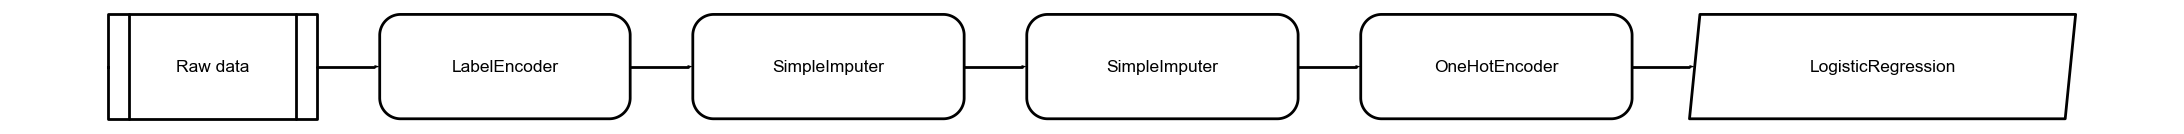

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [20]:
# evaluate trained model
evaluate_model(best)

In [21]:
# predict on hold-out/test set
pred_holdout = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0000,1.0000,0,0,0,1.0000,1.0000


In [22]:
holdout_data = data.copy().drop('difficulty', axis=1)
predictions = predict_model(best, data=holdout_data)

In [23]:
predictions

,clarity,color,cut,carat,depth,price,table,x,y,z,prediction_label,prediction_score
0,VS1,E,Good,0.207014,4.058717,5.793014,4.189655,1.619388,1.623341,1.196948,hard,0.9884
1,VS1,F,Good,0.207014,4.080922,5.998937,4.094345,1.621367,1.625311,1.214913,hard,0.9883
2,VS1,E,Good,0.207014,4.175925,5.998937,4.094345,1.574847,1.578979,1.241269,hard,0.9882
3,VS1,D,Good,0.231112,4.084294,6.001415,4.158883,1.646734,1.656322,1.241269,hard,0.9860
4,VVS1,E,Good,0.231112,4.075841,6.318968,4.110874,1.652497,1.658228,1.238374,hard,0.9832
...,...,...,...,...,...,...,...,...,...,...,...,...
1020,VS2,G,Ideal,0.530628,4.147885,7.909857,4.060443,1.896119,1.902107,1.512927,easy,0.9950
1021,VS2,G,Ideal,0.530628,4.147885,7.909857,4.060443,1.897620,1.902107,1.512927,easy,0.9950
1022,VS2,G,Ideal,0.587787,4.144721,7.911691,4.043051,1.937302,1.945910,1.549688,easy,0.9948
1023,SI1,G,Ideal,0.536493,4.136765,7.915348,4.060443,1.905088,1.911023,1.510722,easy,0.9947


In [24]:
save_model(best, 'best-model.diamonds')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/bq/06qr0b4j0rl0fv6kwt_jr4lw0000gn/T/joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['carat', 'depth', 'price', 'table',
                                              'x', 'y', 'z'],
                                     transformer=SimpleImputer(add_indicator=...
                                                               handle_missing='return_nan',
                                                               handle_unknown='value',
                                                               return_df=True,
                                                               use_cat_names=True,
                                                           

In [25]:
conflict_data = df.loc[df["difficulty"] == "conflict"]
conflict_data.drop(["binary_difficulty", "categorical_difficulty", "numerical_difficulty"], axis=1, inplace=True)

In [26]:
conflict_data

,clarity,color,cut,carat,depth,price,table,x,y,z,difficulty
0,SI2,E,Ideal,0.207014,4.135167,5.789960,4.025352,1.599388,1.605430,1.232560,conflict
1,SI1,E,Premium,0.190620,4.107590,5.789960,4.127134,1.587192,1.576915,1.196948,conflict
3,VS2,I,Premium,0.254642,4.149464,5.814131,4.077537,1.648659,1.654411,1.289233,conflict
4,SI2,J,Good,0.270027,4.163560,5.817111,4.077537,1.675226,1.677097,1.321756,conflict
5,VVS2,J,Very Good,0.215111,4.155753,5.820083,4.060443,1.597365,1.601406,1.247032,conflict
...,...,...,...,...,...,...,...,...,...,...,...
53935,SI1,D,Ideal,0.542324,4.123903,7.922261,4.060443,1.909543,1.911023,1.504077,conflict
53936,SI1,D,Good,0.542324,4.160444,7.922261,4.025352,1.900614,1.909543,1.528228,conflict
53937,SI1,D,Very Good,0.530628,4.155753,7.922261,4.110874,1.896119,1.899118,1.517323,conflict
53938,SI2,H,Premium,0.620576,4.127134,7.922261,4.077537,1.967112,1.962908,1.556037,conflict


In [27]:
conflict_data = conflict_data.copy().drop('difficulty', axis=1)
conflict_predictions = predict_model(best, data=conflict_data)

In [28]:
conflict_predictions["difficulty"] = conflict_predictions["prediction_label"]
conflict_predictions.drop(["prediction_label", "prediction_score"], axis=1, inplace=True)

In [29]:
conflict_predictions

,clarity,color,cut,carat,depth,price,table,x,y,z,difficulty
0,SI2,E,Ideal,0.207014,4.135167,5.789960,4.025352,1.599388,1.605430,1.232560,hard
1,SI1,E,Premium,0.190620,4.107590,5.789960,4.127134,1.587192,1.576915,1.196948,easy
2,VS2,I,Premium,0.254642,4.149464,5.814130,4.077538,1.648659,1.654411,1.289233,easy
3,SI2,J,Good,0.270027,4.163559,5.817111,4.077538,1.675226,1.677097,1.321756,hard
4,VVS2,J,Very Good,0.215111,4.155753,5.820083,4.060443,1.597365,1.601406,1.247032,hard
...,...,...,...,...,...,...,...,...,...,...,...
52910,SI1,D,Ideal,0.542324,4.123903,7.922261,4.060443,1.909543,1.911023,1.504077,easy
52911,SI1,D,Good,0.542324,4.160444,7.922261,4.025352,1.900614,1.909543,1.528228,hard
52912,SI1,D,Very Good,0.530628,4.155753,7.922261,4.110874,1.896119,1.899118,1.517323,easy
52913,SI2,H,Premium,0.620577,4.127134,7.922261,4.077538,1.967112,1.962908,1.556037,hard
